In [796]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

# 데이터 불러오기

In [797]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [798]:
y = df_train['target']
df_train = df_train.drop(columns='target', axis=1)

## 데이터 명목형, 수치형 분류

In [799]:
num_cols = df_train.select_dtypes(include=['int','float']).columns
obj_cols = df_train.select_dtypes(include=['object']).columns

In [800]:
num_cols

Index(['본번', '부번', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '해제사유발생일',
       '단지소개기존clob', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y'],
      dtype='object')

In [801]:
obj_cols

Index(['시군구', '번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'],
      dtype='object')

In [802]:
print(f'전체 col 수 : {len(df_train.columns)}')
print('------------------')
print(f'수치형 col 수 : {len(num_cols)}')
print(f'명목형 col 수 : {len(obj_cols)}')

전체 col 수 : 51
------------------
수치형 col 수 : 22
명목형 col 수 : 29


In [803]:
df_train.head(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


### 명목형 변수

#### 시군구

##### train

In [804]:
df_train['시군구'].isnull().sum()

0

In [805]:
df_train['시'] = df_train['시군구'].str.split(expand=True)[0]
df_train['구'] = df_train['시군구'].str.split(expand=True)[1]
df_train['동'] = df_train['시군구'].str.split(expand=True)[2]

In [806]:
df_train.drop(columns=['시군구'], axis=1, inplace=True)

In [807]:
df_train.head(2)

,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,시,구,동
0,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,서울특별시,강남구,개포동
1,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,서울특별시,강남구,개포동


In [808]:
df_train['시'].value_counts()

서울특별시    1118822
Name: 시, dtype: int64

In [809]:
df_train.drop(columns=['시'], axis=1, inplace=True)

In [810]:
# df_train 의 구 컬럼과 df_test의 구 컬럼은 동일하다
# 궁금하면 아래의 코드를 실행할 것
# df_test['구'].value_counts().index.sort_values() == df_train['구'].value_counts().index.sort_values()
df_train['구'].value_counts() # one-hot-encoding OK

노원구     115099
송파구      73785
강남구      69083
강서구      66610
강동구      61895
구로구      57604
성북구      56675
양천구      53977
서초구      53126
도봉구      52572
영등포구     47640
동작구      40507
마포구      40387
동대문구     39693
성동구      39358
은평구      38283
중랑구      37094
관악구      35967
서대문구     32875
광진구      22070
강북구      21896
용산구      20551
금천구      19586
중구       13388
종로구       9101
Name: 구, dtype: int64

In [811]:
len(df_train['구'].value_counts())

25

In [812]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['구'])], axis=1)

In [813]:
df_train.drop(columns=['구'], axis=1, inplace=True)

In [814]:
df_train['동'].value_counts() # 너무 많은데..

상계동     44948
중계동     26357
신정동     24038
창동      23101
구로동     22811
        ...  
필동1가        6
주성동         5
연지동         4
구수동         3
입정동         1
Name: 동, Length: 337, dtype: int64

In [815]:
df_train.drop(columns=['동'], axis=1, inplace=True)

In [816]:
df_train.head(2)

,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,...,0,0,0,0,0,0,0,0,0,0
1,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,...,0,0,0,0,0,0,0,0,0,0


##### test

In [817]:
df_test['시군구'].isnull().sum()

0

In [818]:
df_test['시'] = df_test['시군구'].str.split(expand=True)[0]
df_test['구'] = df_test['시군구'].str.split(expand=True)[1]
df_test['동'] = df_test['시군구'].str.split(expand=True)[2]

In [819]:
df_test.drop(columns=['시군구'], axis=1, inplace=True)

In [820]:
df_test.head(2)

,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,시,구,동
0,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,언주로 3,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,서울특별시,강남구,개포동
1,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,개포로 311,...,의무,2022-02-23 13:01:10.0,Y,N,127.056394,37.484892,2022-02-23 11:05:05.0,서울특별시,강남구,개포동


In [821]:
df_test['시'].value_counts()

서울특별시    9272
Name: 시, dtype: int64

In [822]:
df_test.drop(columns=['시'], axis=1, inplace=True)

In [823]:
df_test['구'].value_counts() # one-hot-encoding OK

노원구     738
송파구     659
강남구     573
강동구     530
성북구     485
성동구     473
양천구     464
영등포구    457
강서구     431
서초구     427
마포구     423
서대문구    397
은평구     381
구로구     379
동대문구    375
동작구     360
도봉구     300
관악구     276
강북구     241
중랑구     209
광진구     182
금천구     152
중구      146
용산구     131
종로구      83
Name: 구, dtype: int64

In [824]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['구'])], axis=1)

In [825]:
df_test.drop(columns=['구'], axis=1, inplace=True)

In [826]:
df_test['동'].value_counts() # 너무 많은데..

상계동      284
신정동      202
봉천동      197
중계동      167
목동       147
        ... 
안암동3가      1
용문동        1
만리동1가      1
원효로3가      1
묵정동        1
Name: 동, Length: 268, dtype: int64

In [827]:
df_test.drop(columns=['동'], axis=1, inplace=True)

In [828]:
df_test.head()

,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,언주로 3,...,0,0,0,0,0,0,0,0,0,0
1,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,개포로 311,...,0,0,0,0,0,0,0,0,0,0
2,652,652.0,0.0,개포우성3차,161.0000,202307,28,15,1984,개포로 307,...,0,0,0,0,0,0,0,0,0,0
3,652,652.0,0.0,개포우성3차,133.4600,202308,10,14,1984,개포로 307,...,0,0,0,0,0,0,0,0,0,0
4,652,652.0,0.0,개포우성3차,104.4300,202308,18,6,1984,개포로 307,...,0,0,0,0,0,0,0,0,0,0


#### 아파트명

##### train

In [829]:
df_train['아파트명'].value_counts()

현대              16644
신동아             12846
한신               9074
두산               8533
주공2              7918
                ...  
송파레이크파크호반써밋Ⅱ        1
도곡하이빌               1
창동역블루핀1동            1
한강리버힐B동             1
신용산빌딩               1
Name: 아파트명, Length: 6538, dtype: int64

In [830]:
df_train.drop(columns=['아파트명'], axis=1, inplace=True)

##### test

In [831]:
df_test['아파트명'].value_counts()

현대          135
신동아          83
헬리오시티        65
아츠스테이수유점     60
두산           60
           ... 
신촌포스빌         1
보라매삼성쉐르빌      1
상도현대          1
래미안트윈파크       1
롯데관악타워        1
Name: 아파트명, Length: 2170, dtype: int64

In [832]:
df_test.drop(columns=['아파트명'], axis=1, inplace=True)

#### 도로명

##### train & test

In [833]:
len(df_train), len(df_test)

(1118822, 9272)

In [834]:
road_df = pd.concat([df_train['도로명'], df_test['도로명']])

In [835]:
road_df.columns = ['도로명']

In [836]:
road_df['도로명'] = road_df.str.split('로', expand= True)[0] + '로'

In [837]:
road_df['도로명'].value_counts()

동일로          35115
올림픽로         19757
덕릉로          17242
양천로          15826
한글비석로        15416
             ...  
 298로            1
국사봉6길 58로        1
 20-3로           1
 21-9로           1
송정길 32로          1
Name: 0, Length: 856, dtype: int64

In [838]:
le = LabelEncoder()

In [839]:
road_df['도로명'] = le.fit_transform(road_df['도로명'])

In [840]:
df_train['도로명'] = road_df['도로명'][:len(df_train)]
df_test['도로명'] = road_df['도로명'][len(df_train):]

#### 거래유형

1. train data 에는 값이 빈 값이 너무 많아서 사용뷸가 -> drop.columns
2. 빈 값에 해당하는 행을 제거하고 데이터를 축소하여 학습하기 

##### train

In [841]:
df_train['거래유형'].value_counts()

-       1086451
중개거래      29271
직거래        3100
Name: 거래유형, dtype: int64

In [842]:
df_train['거래유형'].isnull().sum()

0

In [843]:
df_train.drop(columns=['거래유형'], axis=1, inplace=True)

##### test

In [844]:
df_test['거래유형'].value_counts()

중개거래    8852
직거래      420
Name: 거래유형, dtype: int64

In [845]:
df_test['거래유형'].isnull().sum()

0

In [846]:
df_test.drop(columns=['거래유형'], axis=1, inplace=True)

#### 중개사소재지

##### train

In [847]:
df_train['중개사소재지'].value_counts()

-                    1089581
서울 강남구                  2000
서울 송파구                  1995
서울 노원구                  1966
서울 강동구                  1597
                      ...   
경기 성남중원구, 서울 노원구           1
서울 강북구, 서울 양천구             1
서울 관악구, 서울 노원구             1
경기 남양주시, 경기 성남수정구          1
서울 동대문구, 인천 연수구            1
Name: 중개사소재지, Length: 643, dtype: int64

In [848]:
df_train.drop(columns=['중개사소재지'], axis=1, inplace = True)

##### test

In [849]:
df_test['중개사소재지'].value_counts()

서울 노원구             661
서울 송파구             545
서울 강남구             508
서울 강동구             441
서울 성북구             435
                  ... 
경기 시흥시, 서울 동대문구      1
서울 도봉구, 서울 동대문구      1
경기 시흥시, 서울 도봉구       1
서울 도봉구, 서울 중랑구       1
서울 성동구, 서울 중랑구       1
Name: 중개사소재지, Length: 357, dtype: int64

In [1079]:
df_test.drop(columns=['중개사소재지'], axis=1, inplace=True)

#### 단지분류

In [851]:
df_train.rename(columns={'k-단지분류(아파트,주상복합등등)' : '단지분류'}, inplace=True)
df_test.rename(columns={'k-단지분류(아파트,주상복합등등)' : '단지분류'}, inplace=True)

##### train

In [852]:
df_train['단지분류'].isnull().sum()

870691

In [853]:
df_train.drop(columns=['단지분류'], axis=1, inplace=True)

##### test

In [854]:
df_test['단지분류'].isnull().sum()

6582

In [855]:
df_test.drop(columns=['단지분류'], axis=1, inplace=True)

#### 전화번호

In [856]:
df_train.rename(columns={'k-전화번호' : '전화번호'}, inplace=True)
df_test.rename(columns={'k-전화번호' : '전화번호'}, inplace=True)

##### train & test

In [857]:
df_train['전화번호'].isnull().sum()

870274

In [858]:
df_test['전화번호'].isnull().sum()

6576

In [859]:
df_train.drop(columns=['전화번호'], axis=1, inplace = True)
df_test.drop(columns=['전화번호'], axis=1, inplace = True)

#### 팩스번호

In [860]:
df_train.rename(columns={'k-팩스번호' : '팩스번호'}, inplace=True)
df_test.rename(columns={'k-팩스번호' : '팩스번호'}, inplace=True)

##### train

In [861]:
df_train['팩스번호'].isnull().sum()

872742

In [862]:
df_train.drop(columns=['팩스번호'], axis=1, inplace=True)

##### test

In [863]:
df_test['팩스번호'].isnull().sum()

6606

In [864]:
df_test.drop(columns=['팩스번호'], axis=1, inplace=True)

#### 세대타입

In [865]:
df_train.rename(columns= {'k-세대타입(분양형태)' : '세대타입'}, inplace=True)
df_test.rename(columns= {'k-세대타입(분양형태)' : '세대타입'}, inplace=True)

##### train

In [866]:
df_train['세대타입'].isnull().sum()

869563

In [867]:
df_train['세대타입'].value_counts()

분양    206371
기타     40686
임대      2202
Name: 세대타입, dtype: int64

In [868]:
df_train.drop(columns=['세대타입'], axis=1, inplace=True)

##### test

In [869]:
df_test['세대타입'].isnull().sum()

6562

In [870]:
df_test['세대타입'].value_counts()

분양    1727
기타     952
임대      31
Name: 세대타입, dtype: int64

In [871]:
df_test.drop(columns=['세대타입'], axis=1, inplace=True)

#### 관리방식

In [872]:
df_train.rename(columns={'k-관리방식' : '관리방식'}, inplace=True)
df_test.rename(columns={'k-관리방식' : '관리방식'}, inplace=True)

##### train

In [873]:
df_train['관리방식'].isnull().sum()

869563

In [874]:
df_train['관리방식'].value_counts()

위탁관리    227842
자치관리     18005
직영        3412
Name: 관리방식, dtype: int64

In [875]:
df_train.drop(columns=['관리방식'], axis=1, inplace=True)

##### test

In [876]:
df_test['관리방식'].isnull().sum()

6562

In [877]:
df_test['관리방식'].value_counts()

위탁관리    2519
자치관리     139
직영        52
Name: 관리방식, dtype: int64

In [878]:
df_test.drop(columns=['관리방식'], axis=1, inplace=True)

#### 복도유형

In [879]:
df_train.rename(columns={'k-복도유형': '복도유형'}, inplace=True)
df_test.rename(columns={'k-복도유형': '복도유형'}, inplace=True)

##### train

In [880]:
df_train['복도유형'].isnull().sum()

869890

In [881]:
df_train['복도유형'].value_counts()

계단식    123651
혼합식     84491
복도식     38383
타워형      1340
기타       1067
Name: 복도유형, dtype: int64

In [882]:
df_train.drop(columns=['복도유형'], axis=1, inplace=True)

##### test

In [883]:
df_test['복도유형'].isnull().sum()

6564

In [884]:
df_test['복도유형'].value_counts()

계단식    1313
혼합식    1022
복도식     327
타워형      31
기타       15
Name: 복도유형, dtype: int64

In [885]:
df_test.drop(columns=['복도유형'], axis=1, inplace=True)

#### 난방방식

In [886]:
df_train.rename(columns={'k-난방방식' : '난방방식'}, inplace=True)
df_test.rename(columns={'k-난방방식' : '난방방식'}, inplace=True)

##### train

In [887]:
df_train['난방방식'].isnull().sum()

869563

In [888]:
df_train['난방방식'].value_counts()

개별난방    150739
지역난방     83891
중앙난방     12591
기타        2038
Name: 난방방식, dtype: int64

In [889]:
df_train.drop(columns=['난방방식'], axis=1, inplace=True)

##### test

In [890]:
df_test['난방방식'].isnull().sum()

6562

In [891]:
df_test['난방방식'].value_counts()

개별난방    1626
지역난방     935
중앙난방      96
기타        53
Name: 난방방식, dtype: int64

In [892]:
df_test.drop(columns=['난방방식'], axis=1, inplace=True)

#### 건설사

In [893]:
df_train.rename(columns={'k-건설사(시공사)' : '건설사'}, inplace=True)
df_test.rename(columns={'k-건설사(시공사)' : '건설사'}, inplace=True)

##### train

In [894]:
df_train['건설사'].isnull().sum()

871058

In [895]:
df_train.drop(columns=['건설사'], axis=1, inplace=True)

##### test

In [896]:
df_test['건설사'].isnull().sum()

6579

In [897]:
df_test.drop(columns=['건설사'], axis=1, inplace=True)

#### 시행사

In [898]:
df_train.rename(columns={'k-시행사' : '시행사'}, inplace=True)
df_test.rename(columns={'k-시행사' : '시행사'}, inplace=True)

##### train

In [899]:
df_train['시행사'].value_counts()

SH공사                     12495
대한주택공사                    7760
도시개발공사                    4241
sh공사                      4153
재건축조합                     4030
                         ...  
장위1구역주택재개발정비사업조합             2
개포우성9차모델링조합                  1
신길3재정비촉진구역주택재개발정비사업조합        1
에이자기관리부동산투자회사 주식회사           1
청명종합건설(주)                    1
Name: 시행사, Length: 555, dtype: int64

In [900]:
df_train['시행사'].isnull().sum()

871254

In [901]:
df_train.drop(columns=['시행사'], axis=1 ,inplace = True)

##### test

In [902]:
df_test['시행사'].value_counts()

SH공사                  109
가락시영아파트주택재건축정비사업조합     65
도시개발공사                 43
sh공사                   41
잠실1단지재건축조합             40
                     ... 
한승                      1
상도동지역주택조합               1
삼익건설아파트재건축조합            1
메트로                     1
묵정아파트 주택조합              1
Name: 시행사, Length: 440, dtype: int64

In [903]:
df_test['시행사'].isnull().sum()

6580

In [904]:
df_test.drop(columns=['시행사'], axis=1 ,inplace = True)

#### 사용검사일-사용승인일

In [905]:
df_train.rename(columns={'k-사용검사일-사용승인일' : '사용검사일-사용승인일'}, inplace=True)
df_test.rename(columns={'k-사용검사일-사용승인일' : '사용검사일-사용승인일'}, inplace=True)

In [906]:
df_train['사용검사일-사용승인일'] = pd.to_datetime(df_train['사용검사일-사용승인일'])
df_test['사용검사일-사용승인일'] = pd.to_datetime(df_test['사용검사일-사용승인일'])

##### train

In [907]:
df_train['사용검사일-사용승인일'].isnull().sum()

869696

<Axes: >

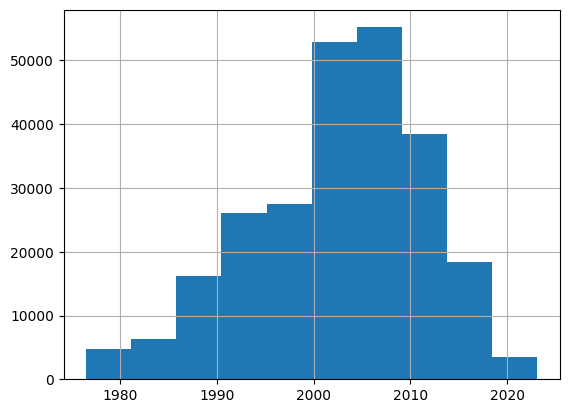

In [908]:
df_train['사용검사일-사용승인일'].hist()

In [909]:
df_train.drop(columns=['사용검사일-사용승인일'], axis=1 , inplace=True)

##### test

In [910]:
df_test['사용검사일-사용승인일'].isnull().sum()

6563

<Axes: >

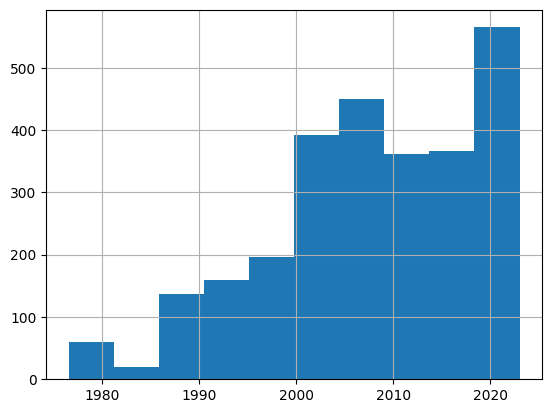

In [911]:
df_test['사용검사일-사용승인일'].hist()

In [912]:
df_test.drop(columns=['사용검사일-사용승인일'], axis=1, inplace=True)

#### 홈페이지

In [913]:
df_train.rename(columns={'k-홈페이지' : '홈페이지'}, inplace=True)
df_test.rename(columns={'k-홈페이지' : '홈페이지'}, inplace=True)

##### train

In [914]:
df_train['홈페이지'].isnull().sum()

1005647

In [915]:
df_train['홈페이지'].value_counts()

없음                                                        3606
www.jsls.co.kr                                            3028
gaepo001@naver.com                                        2816
www.oftapt.com                                            2589
성산시영.apt.co.kr                                            2360
                                                          ... 
www. 자양12구역지역재개발조합                                           6
bbgran.xisad.co.kr                                           6
cafe.naver.com                                               3
thesharp-trieh.hthomeservice.com/#/feeManage?_k=vm58ep       1
http://www.i-sh.co.kr/happy/intro.do                         1
Name: 홈페이지, Length: 221, dtype: int64

In [916]:
df_train.drop(columns=['홈페이지'], axis=1, inplace=True)

##### test

In [917]:
df_test['홈페이지'].isnull().sum()

7876

In [918]:
df_test['홈페이지'].value_counts()

heliocity.com                                             65
www.jsls.co.kr                                            40
nbecastle.aptner.com                                      35
www.kaprugio.com                                          26
성산시영.apt.co.kr                                            25
                                                          ..
.                                                          1
jdcg.apti.co.kr                                            1
보라매삼성쉐르빌.apti.co.kr                                        1
휘경베스트빌현대.apti.co.kr                                        1
thesharp-trieh.hthomeservice.com/#/feeManage?_k=vm58ep     1
Name: 홈페이지, Length: 192, dtype: int64

In [919]:
df_test.drop(columns=['홈페이지'], axis=1, inplace=True)

#### 등록일자, 수정일자

In [920]:
df_train.rename(columns={
    'k-등록일자' : '등록일자',
    'k-수정일자' : '수정일자'
}, inplace=True)

df_test.rename(columns={
    'k-등록일자' : '등록일자',
    'k-수정일자' : '수정일자'
}, inplace=True)

In [921]:
df_train['등록일자'] = pd.to_datetime(df_train['등록일자'])
df_train['수정일자'] = pd.to_datetime(df_train['수정일자'])

df_test['등록일자'] = pd.to_datetime(df_test['등록일자'])
df_test['수정일자'] = pd.to_datetime(df_test['수정일자'])

##### train & test

<Axes: >

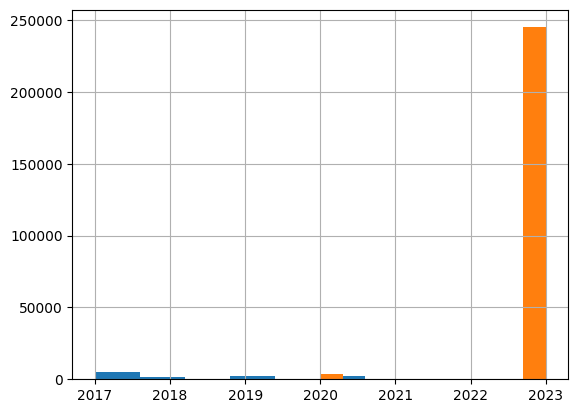

In [922]:
df_train['등록일자'].dt.year.hist()
df_train['수정일자'].dt.year.hist()

<Axes: >

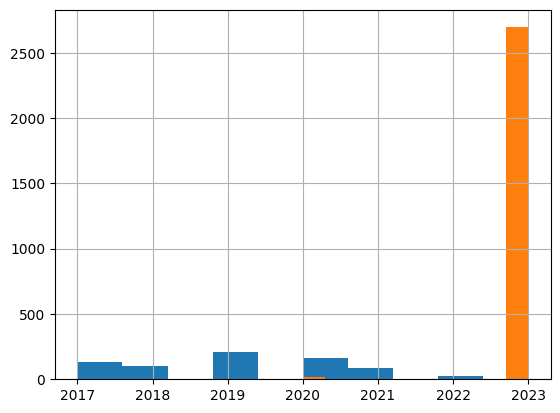

In [923]:
df_test['등록일자'].dt.year.hist()
df_test['수정일자'].dt.year.hist()

In [924]:
df_train.drop(columns=['등록일자', '수정일자'], axis=1, inplace=True)
df_test.drop(columns=['등록일자', '수정일자'], axis=1, inplace=True)

#### 고용관리번호

##### train

In [925]:
df_train['고용보험관리번호'].isnull().sum()

913304

In [926]:
df_train['고용보험관리번호'].value_counts()

909-01-23103-1    3028
21380014370       2816
908-00-99517-1    2562
907-009-67911     2465
907-00-16928-1    2360
                  ... 
92023031541         21
918-15-59912-1      14
91919837281         14
206-82-61203-0       3
21780016330          1
Name: 고용보험관리번호, Length: 526, dtype: int64

In [927]:
df_train.drop(columns=['고용보험관리번호'], axis=1, inplace=True)

##### test

In [928]:
df_test['고용보험관리번호'].isnull().sum()

7453

In [929]:
df_test['고용보험관리번호'].value_counts()

909-01-23103-1    40
92022859891       35
908-00-99517-1    30
91713607381       29
119-80-02925-0    26
                  ..
90700279881        1
90700029131        1
21280065930        1
90700326461        1
91507912231        1
Name: 고용보험관리번호, Length: 403, dtype: int64

In [930]:
df_test.drop(columns=['고용보험관리번호'], axis=1, inplace=True)

#### 경비비관리형태

##### train

In [931]:
df_train['경비비관리형태'].value_counts()

위탁       206401
직영        33526
위탁+직영      6108
기타         1799
Name: 경비비관리형태, dtype: int64

In [932]:
df_train['경비비관리형태'].isnull().sum()

870988

In [933]:
df_train.drop(columns=['경비비관리형태'], axis=1, inplace=True)

##### test

In [934]:
df_test['경비비관리형태'].value_counts()

위탁       2356
직영        265
위탁+직영      60
기타         18
Name: 경비비관리형태, dtype: int64

In [935]:
df_test['경비비관리형태'].isnull().sum()

6573

In [936]:
df_test.drop(columns=['경비비관리형태'], axis=1, inplace=True)

#### 세대전기계약방법

##### train

In [937]:
df_train['세대전기계약방법'].isnull().sum()

878747

In [938]:
df_train['세대전기계약방법'].value_counts()

종합계약    122973
단일계약    117102
Name: 세대전기계약방법, dtype: int64

In [939]:
df_train.drop(columns=['세대전기계약방법'], axis=1, inplace=True)

##### test

In [940]:
df_test['세대전기계약방법'].isnull().sum()

6642

In [941]:
df_test['세대전기계약방법'].value_counts()

종합계약    1637
단일계약     993
Name: 세대전기계약방법, dtype: int64

In [942]:
df_test.drop(columns=['세대전기계약방법'], axis=1, inplace=True)

#### 청소비관리형태

##### train

In [943]:
df_train['청소비관리형태'].isnull().sum()

871178

In [944]:
df_train['청소비관리형태'].value_counts()

위탁       225016
직영        15052
위탁+직영      4127
기타         3449
Name: 청소비관리형태, dtype: int64

In [945]:
df_train.drop(columns=['청소비관리형태'], axis=1, inplace=True)

##### test

In [946]:
df_test['청소비관리형태'].isnull().sum()

6573

In [947]:
df_test['청소비관리형태'].value_counts()

위탁       2495
직영        122
위탁+직영      52
기타         30
Name: 청소비관리형태, dtype: int64

In [948]:
df_test.drop(columns=['청소비관리형태'], axis=1, inplace=True)

#### 기타/의무/임대/임의

In [949]:
print(df_train['기타/의무/임대/임의=1/2/3/4'].isnull().sum())
print(df_test['기타/의무/임대/임의=1/2/3/4'].isnull().sum())

869563
6562


In [950]:
df_train['기타/의무/임대/임의=1/2/3/4'].value_counts()

의무    239198
기타      4177
임의      3682
임대      2202
Name: 기타/의무/임대/임의=1/2/3/4, dtype: int64

In [951]:
df_test['기타/의무/임대/임의=1/2/3/4'].value_counts()

의무    2651
임대      31
임의      19
기타       9
Name: 기타/의무/임대/임의=1/2/3/4, dtype: int64

In [952]:
df_train.drop(columns=['기타/의무/임대/임의=1/2/3/4'], axis=1, inplace=True)
df_test.drop(columns=['기타/의무/임대/임의=1/2/3/4'], axis=1, inplace=True)

#### 단지승인일

> 어쩌면 NAN값은 이사를 하지 않아서 기록되지 않은 값들 아닐까..?

In [953]:
print(df_train['단지승인일'].isnull().sum())
print(df_test['단지승인일'].isnull().sum())

870286
6568


In [954]:
df_train['단지승인일'].head()

0    2022-11-17 13:00:29.0
1    2022-11-17 13:00:29.0
2    2022-11-17 13:00:29.0
3    2022-11-17 13:00:29.0
4    2022-11-17 13:00:29.0
Name: 단지승인일, dtype: object

In [955]:
df_train.drop(columns=['단지승인일'], axis=1, inplace=True)
df_test.drop(columns=['단지승인일'], axis=1, inplace=True)

##### 사용허가여부

> value_counts 결과 Y 값만 존재 -> 따라서 결측치는 N 이라고 예상  
> 만약 모델 성능이 좋지 않으면 drop 해야 할지도 by. 단순히 기록이 누락된 경우일 수 있기 때문에

In [956]:
df_train['사용허가여부'].value_counts()

Y    249259
Name: 사용허가여부, dtype: int64

In [957]:
df_test['사용허가여부'].value_counts()

Y    2710
Name: 사용허가여부, dtype: int64

In [958]:
df_train['사용허가여부'] = df_train['사용허가여부'].fillna('N')
df_test['사용허가여부'] = df_test['사용허가여부'].fillna('N')

In [959]:
df_train['사용허가여부'] = df_train['사용허가여부'].map(lambda x : 1 if x == 'Y' else 0)
df_test['사용허가여부'] = df_test['사용허가여부'].map(lambda x : 1 if x == 'Y' else 0)

In [960]:
print(df_train['사용허가여부'].value_counts())
print('------------------------------------')
print(df_test['사용허가여부'].value_counts())

0    869563
1    249259
Name: 사용허가여부, dtype: int64
------------------------------------
0    6562
1    2710
Name: 사용허가여부, dtype: int64


#### 관리비 업로드

In [961]:
df_train['관리비 업로드'].value_counts()

N    245117
Y      4142
Name: 관리비 업로드, dtype: int64

In [962]:
df_test['관리비 업로드'].value_counts()

N    2671
Y      39
Name: 관리비 업로드, dtype: int64

In [963]:
print(df_train['관리비 업로드'].isnull().sum())
print(df_test['관리비 업로드'].isnull().sum())

869563
6562


In [964]:
df_train.drop(columns=['관리비 업로드'], axis=1, inplace=True)
df_test.drop(columns=['관리비 업로드'], axis=1, inplace=True)

#### 단지신청일

In [965]:
df_train['단지신청일'].isnull().sum()

869625

In [966]:
df_train.drop(columns=['단지신청일'], axis=1, inplace=True)
df_test.drop(columns=['단지신청일'], axis=1, inplace=True)

### 복합 변수

#### 번지 = 본번 + 부번

##### train

In [967]:
print(len(df_train), ",",len(df_test))

1118822 , 9272


In [968]:
print(df_train['번지'].isnull().sum())
print(df_train['본번'].isnull().sum())
print(df_train['부번'].isnull().sum())

225
75
75


In [969]:
df_train[df_train['본번'].isnull()].index == df_train[df_train['부번'].isnull()].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [970]:
df_train[df_train['본번'].isnull()]['번지'].isnull().sum()

75

In [971]:
df_train = df_train.drop(index=df_train[df_train['본번'].isnull()].index)
df_train = df_train.reset_index(drop=True)
len(df_train)

1118747

In [972]:
print(df_train['번지'].isnull().sum())

150


In [973]:
df_train.drop(columns=['번지'], axis=1, inplace=True)

In [974]:
df_train.head(2)

,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,658.0,1.0,79.97,201712,8,3,1987,556,NaN,,...,0,0,0,0,0,0,0,0,0,0
1,658.0,1.0,79.97,201712,22,4,1987,556,NaN,,...,0,0,0,0,0,0,0,0,0,0


##### test

In [975]:
print(df_test['번지'].isnull().sum())
print(df_test['본번'].isnull().sum())
print(df_test['부번'].isnull().sum())

2
0
0


In [976]:
df_test.drop(columns=['번지'], axis=1 , inplace=True)

In [977]:
df_test.head(2)

,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,658.0,1.0,79.9700,202307,26,5,1987,556,NaN,,...,0,0,0,0,0,0,0,0,0,0
1,651.0,1.0,108.2017,202308,15,10,2021,44,NaN,,...,0,0,0,0,0,0,0,0,0,0


### 수치형 변수

#### 전용면적

In [978]:
df_train.rename(columns={"전용면적(㎡)":"전용면적"}, inplace=True)
df_test.rename(columns={"전용면적(㎡)":"전용면적"}, inplace=True)

##### train

In [979]:
df_train['전용면적'].isnull().sum()

0

##### test

In [980]:
df_test['전용면적'].isnull().sum()

0

#### 계약년월 + 계약일

##### train

In [981]:
df_train['계약년월'].isnull().sum()

0

In [982]:
df_train['계약_year'] = pd.to_datetime(df_train['계약년월'], format="%Y%m").dt.year
df_train['계약_month'] = pd.to_datetime(df_train['계약년월'], format="%Y%m").dt.month

In [983]:
df_train[['계약_year','계약_month']].head()

,계약_year,계약_month
0,2017,12
1,2017,12
2,2017,12
3,2018,1
4,2018,1


In [984]:
df_train.drop(columns=['계약년월'], axis=1, inplace=True)

##### test

In [985]:
df_test['계약년월'].isnull().sum()

0

In [986]:
df_test['계약_year'] = pd.to_datetime(df_test['계약년월'], format="%Y%m").dt.year
df_test['계약_month'] = pd.to_datetime(df_test['계약년월'], format="%Y%m").dt.month

In [987]:
df_test[['계약_year','계약_month']].head()

,계약_year,계약_month
0,2023,7
1,2023,8
2,2023,7
3,2023,8
4,2023,8


In [988]:
df_test.drop(columns=['계약년월'], axis=1, inplace=True)

##### 계약일

In [989]:
df_train.rename(columns={"계약일" : "계약_day"}, inplace=True)
df_train['계약_day'].isnull().sum()

0

In [990]:
df_test.rename(columns={"계약일" : "계약_day"}, inplace=True)
df_test['계약_day'].isnull().sum()

0

#### 층

##### train

In [991]:
df_train['층'].isnull().sum()

0

In [992]:
df_train['층'].unique()

array([ 3,  4,  5,  2,  1,  8,  6, 10, 12, 14, 11, 15, 19, 16, 18, 21,  7,
       13,  9, 22, 20, 26, 17, 24, 29, 23, 25, 27, 34, 30, 32, 28, 46, 44,
       45, 35, 38, 37, 40, 36, 48, 54, 43, 42, 60, 57, 33, 49, 55, 53, 47,
       41, 52, 39, 51, 68, 58, 59, 62, 63, 31, 50, -2, -1, 56, 65, 66, 67,
       69, -3, -4, 64, 61])

In [993]:
train_drop_index = df_train[df_train['층'] <= 0].index

In [994]:
df_train = df_train.drop(train_drop_index).reset_index(drop=True)

##### test

In [995]:
df_test['층'].isnull().sum()

0

In [996]:
df_test['층'].unique()

array([ 5, 10, 15, 14,  6,  8, 11, 12,  9, 26, 17, 13,  7,  4, 18, 27,  3,
        2,  1, 22, 20, 19, 16, 23, 25, 35, 28, 24, 21, 33, 43, 34, 55, 50,
       38, 41, 53, 45, 62, 58, 32, 30, 29, 42, 39, 36, 40, 31, 37, 44, 46,
       65, -1, -3])

In [997]:
test_drop_index = df_test[df_test['층'] <= 0].index

In [998]:
df_test = df_test.drop(test_drop_index).reset_index(drop=True)

#### 건축년도

##### train

In [999]:
df_train['건축년도'].isnull().sum()

0

##### test

In [1000]:
df_train['건축년도'].isnull().sum()

0

#### 등기신청일자

##### train & test

In [1001]:
df_train['등기신청일자'].value_counts()

            1103572
20230630        585
20230428        394
20230831        391
20230530        367
             ...   
20230110          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [1002]:
df_test['등기신청일자'].value_counts()

            7361
20230915     146
20230920     107
20230831     105
20230828     100
20230908      84
20230918      74
20230830      70
20230825      65
20230901      63
20230914      61
20230921      56
20230911      56
20230904      54
20230818      49
20230913      45
20230919      42
20230905      42
20230824      41
20230912      39
20230811      35
20230907      31
20230821      31
20230906      30
20230810      29
20230829      29
20230922      29
20230814      28
20230816      28
20230727      27
20230817      26
20230731      22
20230728      22
20230822      19
20230725      19
20230823      18
20230807      15
20230809      15
20230808      14
20230803      14
20230802      13
20230726      13
20230720      11
20230721      10
20230724       9
20230801       8
20230804       7
20230711       7
20230718       6
20230719       6
20230706       6
20230714       6
20230717       6
20230710       5
20230713       5
20230712       4
20230705       2
20230707       2
20230703      

In [1003]:
df_train.drop(columns=['등기신청일자'], axis=1, inplace = True)
df_test.drop(columns=['등기신청일자'], axis=1, inplace = True)

#### 해제사유발생일

##### train

In [1004]:
df_train['해제사유발생일'].isnull().sum()

1112509

In [1005]:
df_train['해제사유발생일'] = df_train['해제사유발생일'].apply(lambda x: 1 if pd.notna(x) else 0)

##### test

In [1006]:
df_test['해제사유발생일'].isnull().sum()

9057

In [1007]:
df_test['해제사유발생일'] = df_test['해제사유발생일'].apply(lambda x: 1 if pd.notna(x) else 0)

#### 단지소개기존

In [1008]:
df_train = df_train.rename(columns={'단지소개기존clob' : '단지소개기존'})
df_test = df_test.rename(columns={'단지소개기존clob' : '단지소개기존'})

##### train

In [1009]:
df_train['단지소개기존'].isnull().sum()

1049909

In [1010]:
df_train['단지소개기존'].value_counts()

4.0       23845
1474.0     2465
638.0      2346
301.0      2093
2315.0     1558
          ...  
2039.0      118
63.0        113
217.0       111
24.0        107
1417.0       51
Name: 단지소개기존, Length: 94, dtype: int64

In [1011]:
df_train.drop(columns=['단지소개기존'], axis=1, inplace=True)

##### test

In [1012]:
df_test['단지소개기존'].isnull().sum()

8715

In [1013]:
df_test.drop(columns=['단지소개기존'], axis=1, inplace=True)

#### 전체동수

In [1014]:
df_train.rename(columns={'k-전체동수' : '전체동수'}, inplace=True)
df_test.rename(columns={'k-전체동수' : '전체동수'}, inplace=True)

##### train

In [1015]:
df_train['전체동수'].isnull().sum()

870326

<Axes: >

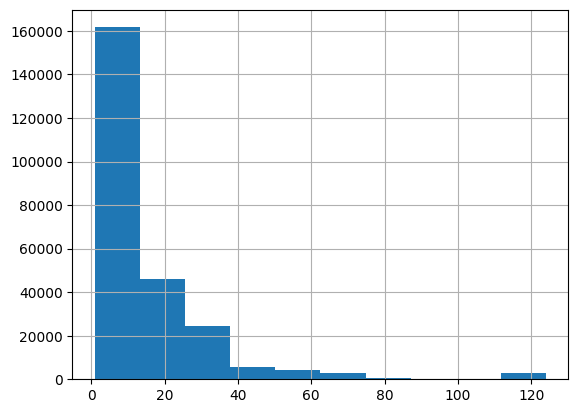

In [1016]:
df_train['전체동수'].hist()

In [1017]:
df_train.drop(columns=['전체동수'], axis=1, inplace=True)

##### test

In [1018]:
df_test['전체동수'].isnull().sum()

6575

<Axes: >

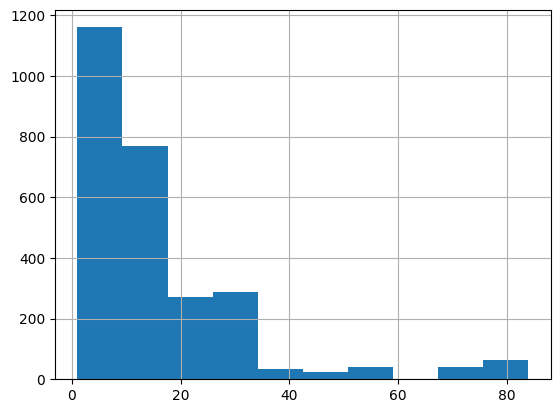

In [1019]:
df_test['전체동수'].hist()

In [1020]:
df_test.drop(columns=['전체동수'], axis=1, inplace=True)

In [1021]:
a = ['k-전체세대수',
       'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일']

In [1022]:
len(a)

27

#### 전체세대수

In [1023]:
df_train.rename(columns={'k-전체세대수' : '전체세대수'}, inplace = True)
df_test.rename(columns={'k-전체세대수' : '전체세대수'}, inplace = True)

##### train

In [1024]:
df_train['전체세대수'].isnull().sum()

869259

<Axes: >

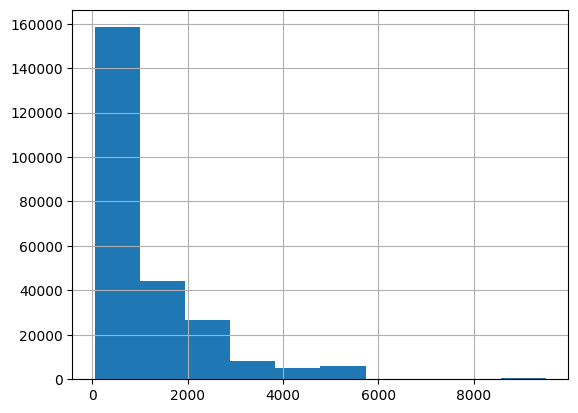

In [1025]:
df_train['전체세대수'].hist()

In [1026]:
df_train.drop(columns=['전체세대수'], axis=1, inplace=True)

##### test

In [1027]:
df_test['전체세대수'].isnull().sum()

6560

<Axes: >

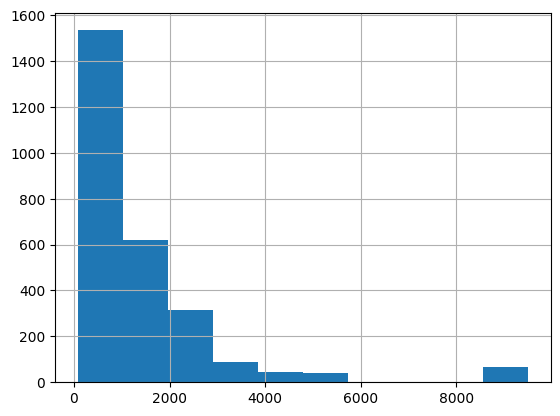

In [1028]:
df_test['전체세대수'].hist()

In [1029]:
df_test.drop(columns=['전체세대수'], axis=1, inplace=True)

In [1030]:
df_train.columns

Index(['본번', '부번', '전용면적', '계약_day', '층', '건축년도', '도로명', '해제사유발생일', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', '사용허가여부', '좌표X', '좌표Y',
       '강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
       '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
       '용산구', '은평구', '종로구', '중구', '중랑구', '계약_year', '계약_month'],
      dtype='object')

#### 연면적

In [1031]:
df_train.rename(columns={'k-연면적' : '연면적'}, inplace=True)
df_test.rename(columns={'k-연면적' : '연면적'}, inplace=True)

##### train

In [1032]:
df_train['연면적'].isnull().sum()

869259

<Axes: >

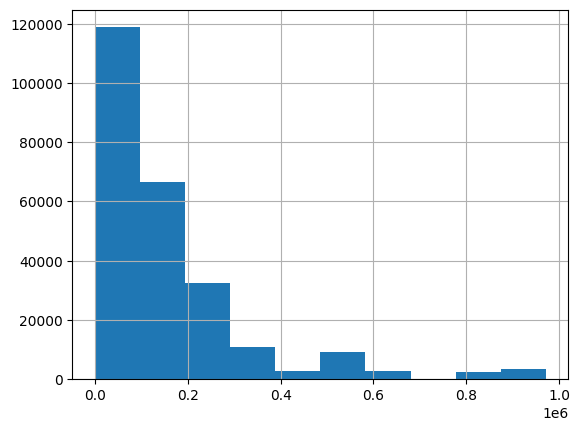

In [1033]:
df_train[df_train['연면적'] < 2000000.0]['연면적'].hist()

In [1034]:
df_train.drop(columns=['연면적'], axis=1, inplace=True)

##### test

In [1035]:
df_test['연면적'].isnull().sum()

6560

<Axes: >

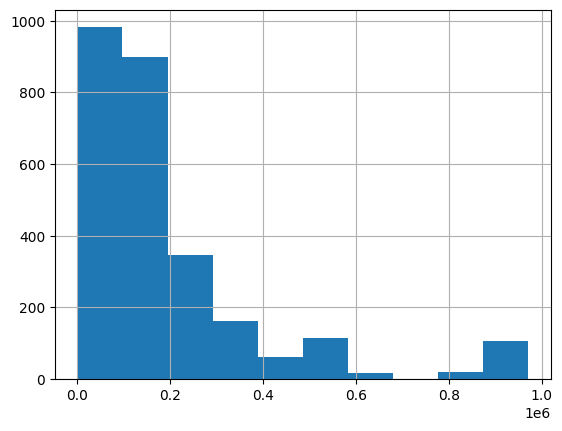

In [1036]:
df_test[df_test['연면적'] < 2000000.0]['연면적'].hist()

In [1037]:
df_test.drop(columns=['연면적'], axis=1, inplace=True)

#### 주거전용면적

In [1038]:
df_train.rename(columns={'k-주거전용면적' : '주거전용면적'}, inplace=True)
df_test.rename(columns={'k-주거전용면적' : '주거전용면적'}, inplace=True)

##### train

In [1039]:
df_train['주거전용면적'].isnull().sum()

869304

<Axes: >

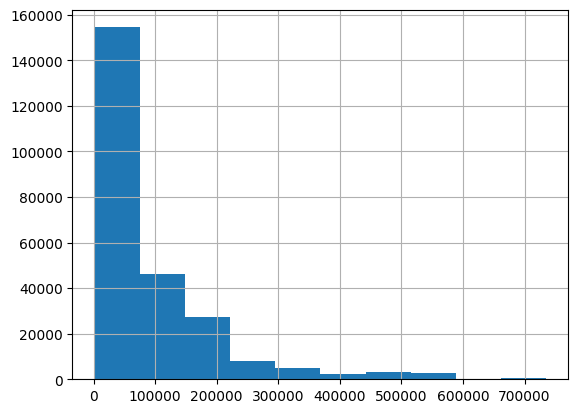

In [1040]:
df_train['주거전용면적'].hist()

In [1041]:
df_train.drop(columns=['주거전용면적'], axis = 1, inplace=True)

##### test

In [1042]:
df_test['주거전용면적'].isnull().sum()

6560

<Axes: >

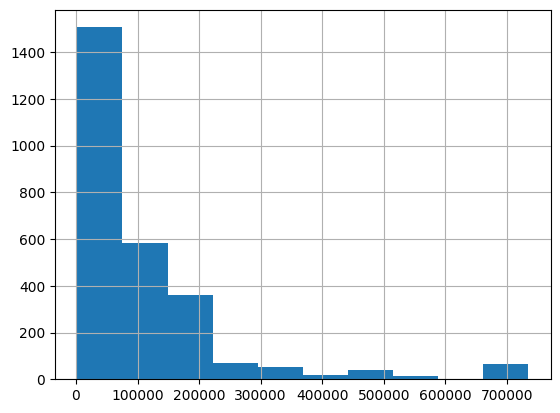

In [1043]:
df_test['주거전용면적'].hist()

In [1044]:
df_test.drop(columns=['주거전용면적'], axis=1, inplace=True)

#### 관리비부과면적

In [1045]:
df_train.rename(columns={'k-관리비부과면적' : '관리비부과면적'}, inplace=True)
df_test.rename(columns={'k-관리비부과면적' : '관리비부과면적'}, inplace=True)

##### train

In [1046]:
df_train['관리비부과면적'].isnull().sum()

869259

<Axes: >

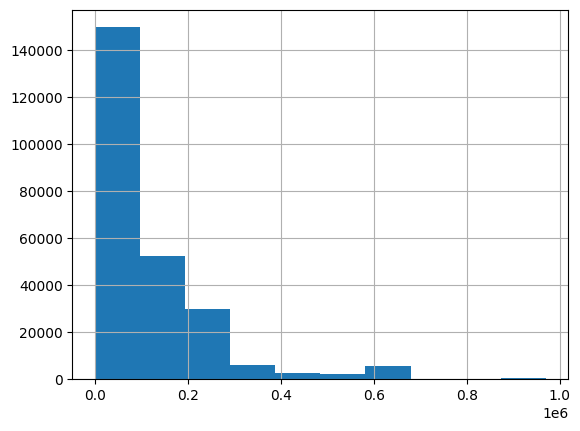

In [1047]:
df_train['관리비부과면적'].hist()

In [1048]:
df_train.drop(columns=['관리비부과면적'], axis=1, inplace=True)

##### test

In [1049]:
df_test['관리비부과면적'].isnull().sum()

6560

<Axes: >

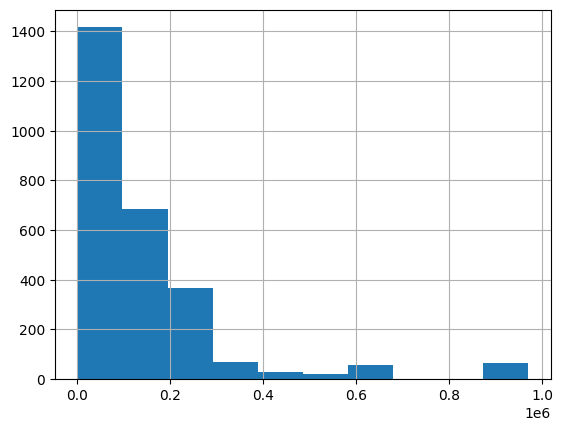

In [1050]:
df_test['관리비부과면적'].hist()

In [1051]:
df_test.drop(columns=['관리비부과면적'], axis=1, inplace=True)

#### 전용면적별세대현황

In [1052]:
df_train.rename(
    columns={
        'k-전용면적별세대현황(60㎡이하)' : '60이하',
        'k-전용면적별세대현황(60㎡~85㎡이하)' : '85이하',
        'k-85㎡~135㎡이하' : '135이하',
        'k-135㎡초과' : '135초과'
    }, inplace=True
)

df_test.rename(
    columns={
        'k-전용면적별세대현황(60㎡이하)' : '60이하',
        'k-전용면적별세대현황(60㎡~85㎡이하)' : '85이하',
        'k-85㎡~135㎡이하' : '135이하',
        'k-135㎡초과' : '135초과'
    }, inplace=True
)

In [1053]:
tmp_cols = ['60이하', '85이하','135이하', '135초과']

In [1054]:
df_train[tmp_cols] = df_train[tmp_cols].fillna(0)
df_test[tmp_cols] = df_test[tmp_cols].fillna(0)

In [1055]:
df_train['관리비부과면적'] = df_train[tmp_cols[0]] * 1 + df_train[tmp_cols[1]] * 2 + df_train[tmp_cols[2]] * 3 + df_train[tmp_cols[3]] * 4
df_test['관리비부과면적'] = df_test[tmp_cols[0]] * 1 + df_test[tmp_cols[1]] * 2 + df_test[tmp_cols[2]] * 3 + df_test[tmp_cols[3]] * 4

In [1056]:
df_train.drop(columns=tmp_cols, axis=1, inplace=True)
df_test.drop(columns=tmp_cols, axis=1, inplace=True)

#### 건축면적

##### train

In [1057]:
df_train['건축면적'].isnull().sum()

869410

<Axes: >

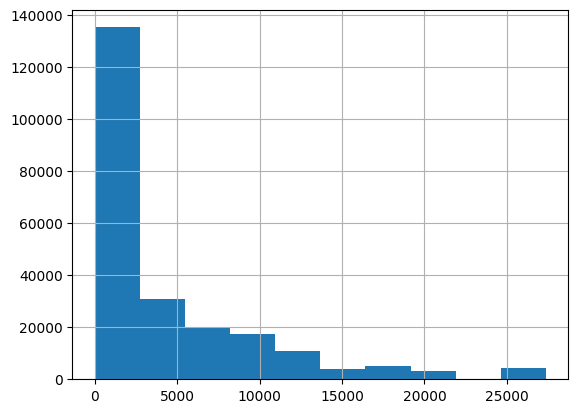

In [1058]:
df_train[df_train['건축면적'] < 0.3 * 1e5]['건축면적'].hist()

In [1059]:
df_train.drop(columns = ['건축면적'], axis=1, inplace=True)

##### test

In [1060]:
df_test['건축면적'].isnull().sum()

6563

<Axes: >

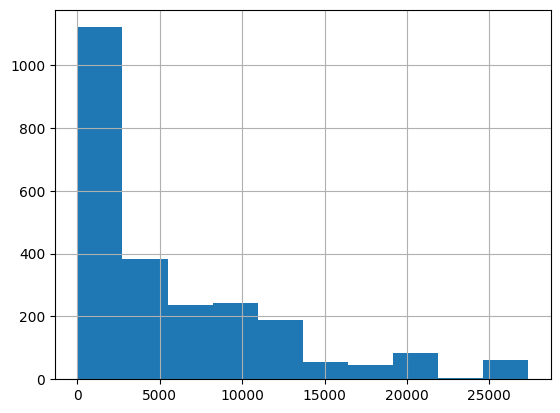

In [1061]:
df_test[df_test['건축면적'] < 0.3 * 1e5]['건축면적'].hist()

In [1062]:
df_test.drop(columns = ['건축면적'], axis=1, inplace=True)

#### 주차대수

##### train

In [1063]:
df_train['주차대수'].isnull().sum()

869410

<Axes: >

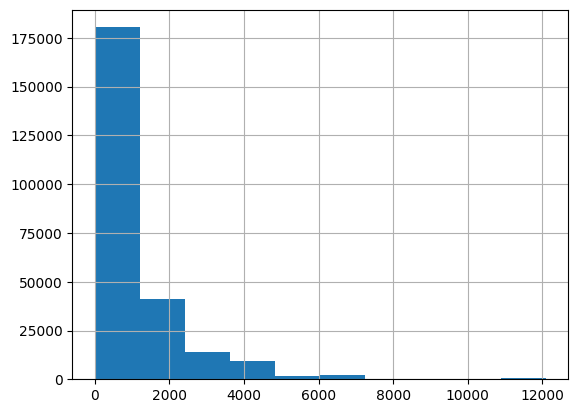

In [1064]:
df_train['주차대수'].hist()

In [1065]:
df_train.drop(columns=['주차대수'], axis=1, inplace=True)

##### test

In [1066]:
df_test['주차대수'].isnull().sum()

6561

<Axes: >

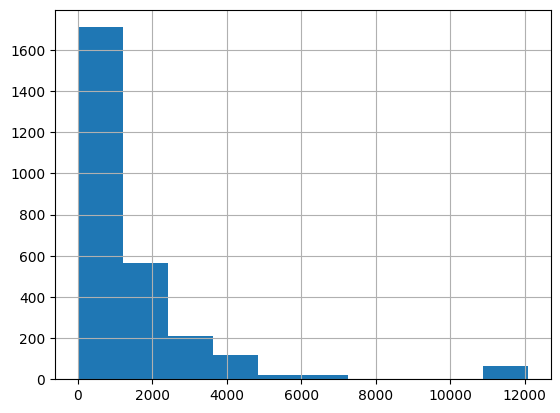

In [1067]:
df_test['주차대수'].hist()

In [1068]:
df_test.drop(columns=['주차대수'], axis=1, inplace=True)

#### 좌표X, 좌표Y

> 본번이 똑같은 행이면 각 X, Y값을 평균을 내 NAN 값 채워보기

In [1069]:
df_train['좌표X'].isnull().sum()

869366

In [1070]:
x_nan = df_train[df_train['좌표X'].isnull() == True].index.tolist()

In [1071]:
# 그룹화하여 '본번' 값에 대해 각 '좌표X'와 '좌표Y'의 평균을 계산
df_train[['좌표X', '좌표Y']] = df_train.groupby('본번')[['좌표X', '좌표Y']].transform(lambda x: x.fillna(x.mean()))

In [1072]:
df_train['좌표X'].isnull().sum()

494320

In [1073]:
df_train['좌표Y'].isnull().sum()

494320

In [1074]:
df_train.drop(columns=['좌표X', '좌표Y'], axis=1, inplace=True)
df_test.drop(columns=['좌표X', '좌표Y'], axis=1, inplace=True)

In [1080]:
df_train.columns

Index(['본번', '부번', '전용면적', '계약_day', '층', '건축년도', '도로명', '해제사유발생일', '사용허가여부',
       '강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
       '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
       '용산구', '은평구', '종로구', '중구', '중랑구', '계약_year', '계약_month', '관리비부과면적'],
      dtype='object')

In [1081]:
df_test.columns

Index(['본번', '부번', '전용면적', '계약_day', '층', '건축년도', '도로명', '해제사유발생일', '사용허가여부',
       '강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
       '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
       '용산구', '은평구', '종로구', '중구', '중랑구', '계약_year', '계약_month', '관리비부과면적'],
      dtype='object')

In [1082]:
len(df_train.columns)

37

In [1083]:
len(df_test.columns)

37

In [1084]:
df_train.to_csv("../data/pre_train.csv", encoding='utf-8', index=False)
df_test.to_csv("../data/pre_test.csv", encoding='utf-8', index=False)